### Step 1: Initialize the SerpAPI Search Tool

This cell loads your SerpAPI key from a `.env` file using `python-dotenv` and initializes the `SerpAPIWrapper` from LangChain Community utilities. It performs a simple web search to answer the question "Who's the current President of France?" and prints the result.

In [1]:
import os
from dotenv import load_dotenv
from langchain_community.utilities import SerpAPIWrapper
from langchain.tools import tool

load_dotenv()

api_key = os.getenv("SERPAPI_API_KEY") # https://serpapi.com/

@tool
def search_tool(query: str) -> str:
    """Searches the web using SerpAPI and returns the top result snippet."""
    from langchain_community.utilities import SerpAPIWrapper
    search = SerpAPIWrapper()
    return search.run(query)
    
print(search_tool.run("Who's the current President of France?"))

Emmanuel Macron


### Step 2: Create a Dummy Weather Tool

Here, we define a simple function to simulate fetching weather data for a given location. The function randomly selects from a few predefined weather conditions and temperatures. We then wrap this function using `Tool` from LangChain to make it usable in a tool-enabled agent.


In [2]:
from langchain.tools import Tool
import random

def get_weather_info(location: str) -> str:
    """Fetches dummy weather information for a given location."""
    # Dummy weather data
    weather_conditions = [
        {"condition": "Rainy", "temp_c": 15},
        {"condition": "Clear", "temp_c": 25},
        {"condition": "Windy", "temp_c": 20}
    ]
    # Randomly select a weather condition
    data = random.choice(weather_conditions)
    return f"Weather in {location}: {data['condition']}, {data['temp_c']}°C"

# Initialize the tool
weather_info_tool = Tool(
    name="get_weather_info",
    func=get_weather_info,
    description="Fetches dummy weather information for a given location."
)

### Step 3: Create a Hugging Face Hub Stats Tool

This cell defines a function that fetches the most downloaded model from a given author on the Hugging Face Hub using the `huggingface_hub` SDK. It is wrapped as a LangChain tool and invoked with `"facebook"` as an example, returning the top model by download count.

In [3]:
from langchain.tools import Tool
from huggingface_hub import list_models

def get_hub_stats(author: str) -> str:
    """Fetches the most downloaded model from a specific author on the Hugging Face Hub."""
    try:
        # List models from the specified author, sorted by downloads
        models = list(list_models(author=author, sort="downloads", direction=-1, limit=1))

        if models:
            model = models[0]
            return f"The most downloaded model by {author} is {model.id} with {model.downloads:,} downloads."
        else:
            return f"No models found for author {author}."
    except Exception as e:
        return f"Error fetching models for {author}: {str(e)}"

# Initialize the tool
hub_stats_tool = Tool(
    name="get_hub_stats",
    func=get_hub_stats,
    description="Fetches the most downloaded model from a specific author on the Hugging Face Hub."
)

# Example usage
print(hub_stats_tool("facebook")) # Example: Get the most downloaded model by Facebook

/tmp/ipykernel_102294/3056453286.py:26: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(hub_stats_tool("facebook")) # Example: Get the most downloaded model by Facebook


The most downloaded model by facebook is facebook/esmfold_v1 with 15,316,230 downloads.


### Step 4: Build the LangGraph Agent with Tool Support

This cell sets up a LangGraph workflow where an assistant (based on Hugging Face's `Qwen2.5-Coder-32B-Instruct` model) can automatically decide when to use tools.

- Tools are bound to the LLM using `bind_tools()`.
- `StateGraph` is used to define the agent's flow, starting at the `assistant` node.
- If the assistant determines a tool is needed (`tools_condition`), control moves to the `tools` node and loops back.

Finally, a sample user message is passed into the graph to demonstrate the tool-augmented assistant's response.


In [4]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# Generate the chat interface, including the tools
load_dotenv()
api_key = os.getenv("HUGGINGFACEHUB_API_TOKEN")

llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct",
    huggingfacehub_api_token=api_key,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [search_tool, weather_info_tool, hub_stats_tool]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

messages = [HumanMessage(content="Who is Facebook and what's their most popular model?")]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
It seems like there might be some confusion. Facebook, as a social media platform, does not typically release or have a "most popular model" like a technology company specializing in AI might. However, Meta (the parent company of Facebook) has been very active in the field of artificial intelligence and has released several models. The most downloaded AI model by Meta, according to the information you provided, is `esmfold_v1` with 15,316,230 downloads. 

This model is related to bioinformatics, specifically for predicting the structure of proteins. If you are looking for information on models that are more directly related to social media functionality on Facebook, the context might be different, as Facebook's internal models often serve specific purposes like content ranking, recommendation systems, and ad targeting, but are not publicly available or widely downloaded in the same way.

If you need more information about a specific type of model or functionality w

### Visualize the Agent Graph

This cell renders the graph created in the previous step using Mermaid, displaying the interaction between the assistant node and the tools node.

This visual helps understand the decision-making flow: starting at the assistant, optionally invoking tools, and then cycling back for further processing.

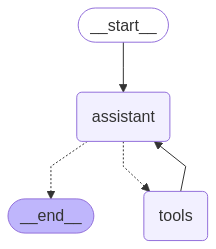

In [5]:
from IPython.display import Image, display
compiled_graph = builder.compile()
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

### Summary: Tool-Augmented Agent Using LangGraph and Hugging Face

In this notebook, we built a tool-augmented conversational agent using **LangChain**, **LangGraph**, and a **Hugging Face language model**. The workflow included:

1. **Tool Creation**: We defined several tools, including a SerpAPI-based web search, a mock weather reporter, and a Hugging Face Hub statistics retriever. These were registered using LangChain’s `@tool` decorator or `Tool` wrapper.

2. **Tool Binding**: We instantiated a chat model from Hugging Face (`Qwen2.5-Coder-32B-Instruct`) and bound the tools to it using `bind_tools`, enabling the model to call tools when appropriate.

3. **Agent Graph**: We built an agent using `StateGraph` with an assistant node and a tool node. The assistant decides whether to respond directly or invoke a tool using `tools_condition`.

4. **Execution and Visualization**: A sample user query demonstrated the full tool-augmented agent in action, and we visualized the control flow using a Mermaid-based graph.

This setup demonstrates how to integrate LLMs and tools within a structured and extensible agent framework, supporting dynamic decision-making and automated tool usage.